In [1]:
%matplotlib inline
from IPython.core.display import HTML, display
HTML("<style>.container { width:100% !important; }</style>")

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


/home/ubuntu/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import pandas as pd
import numpy as np
# import emoji lists from data.sentiment_dict
from Data.sentiment_dict import positive, negative
from sklearn.feature_extraction import DictVectorizer
pd.options.display.max_colwidth=250
pd.options.display.max_columns=999

In [3]:
# separate tweet into parts with emojis of interest and the rest
def separate_emoji(tweet, emojis):
    emojis = set(tweet).intersection(emojis)
    text = ''
    for i in tweet:
        if i not in emojis:
            text += i
    return text, dict.fromkeys(emojis,1)

In [4]:
# specify the location of the tweets
negtweet_file ='./Data/negtweets.txt'
postweet_file ='./Data/postweets.txt'

In [5]:
# initial lists, one for tweets, one for emoji of interest
tweet_df = [] # so far, it is just lists
emoji_df = []
# load all the tweets from positive file
with open(postweet_file,'r') as f:
    for line in f:
        tweet = line.decode('utf-8')
        emojis = positive+negative
        text_i, emojis_i =separate_emoji(tweet, emojis)
        emoji_df.append(emojis_i) 
        tweet_df.append(text_i)
# load all the tweets from negative file
with open(negtweet_file,'r') as f:
    for line in f:
        tweet = line.decode('utf-8')
        emojis = positive+negative
        text_i, emojis_i =separate_emoji(tweet, emojis)
        emoji_df.append(emojis_i) 
        tweet_df.append(text_i)

# convert data into dataframe
tweet_df = pd.DataFrame(tweet_df, columns=['tweet'])
DV=DictVectorizer()
emoji_df=DV.fit_transform(emoji_df) # this is actually a vector, or matrix, not a df
emoji_list = {}
for i in DV.feature_names_:
    emoji_list[i.encode('raw_unicode_escape')] = i
emoji_list=pd.DataFrame(emoji_list, index=[0])
emoji_list = emoji_list[[i.encode('raw_unicode_escape') for i in DV.feature_names_]]
emoji_df=pd.DataFrame(emoji_df.toarray(), columns=[i.encode('raw_unicode_escape') for i in DV.feature_names_])

In [6]:
positive_columns = [i.encode('raw_unicode_escape') for i in positive]
negative_columns = [i.encode('raw_unicode_escape') for i in negative]

In [7]:
emoji_list

,\u2639,\u263a,\U0001f600,\U0001f601,\U0001f602,\U0001f603,\U0001f604,\U0001f606,\U0001f607,\U0001f60a,...,\U0001f626,\U0001f627,\U0001f628,\U0001f629,\U0001f62d,\U0001f630,\U0001f631,\U0001f638,\U0001f641,\U0001f642
0,☹,☺,😀,😁,😂,😃,😄,😆,😇,😊,...,😦,😧,😨,😩,😭,😰,😱,😸,🙁,🙂


In [168]:
display(tweet_df.head(10))

,tweet
0,bro that's so depressing.. Let's go to his house 🙄\n
1,thank you thank you for telling me about them omg i love them ❤x\n
2,"Excellent day at work, laughed all day. Blessed to do my job. #crewlife #averybritishairline #post2276gettingthere 👏🏻 \n"
3,Things are getting there \n
4,I'm so proud of you! Welcome to the team!! #BellLetsTalk #SickNotWeak \n
5,please follow me #BellLetsTalk X18\n
6,thanks girl 💕\n
7,2 weeks from today \n
8,'s snapchats cheer me up so much\n
9,I'm not sure if I'm going yet \n


In [9]:
# combine tweet_df with emoji_df
tweet_with_emoji_df = tweet_df.copy()
tweet_with_emoji_df[emoji_df.columns] = emoji_df.copy()
tweet_with_emoji_df['label'] = tweet_with_emoji_df[positive_columns].sum(axis=1).map(lambda x: x>=1)

In [10]:
from sklearn.cross_validation import train_test_split
(train_data, test_data) = train_test_split(tweet_with_emoji_df,random_state=0)

In [11]:
data_samples = train_data.tweet.values
# data_samples=np.hstack((train_data.tweet.values, test_data.tweet.values))
# data_samples = tweet_with_emoji_df.tweet.values

In [12]:
# tweet_with_emoji_df.head()
# test_data.shape


In [38]:
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [14]:
n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()



In [15]:
# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, #max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

Extracting tf-idf features for NMF...
done in 0.627s.


In [16]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with tf-idf features,"
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

print("Fitting LDA models with tf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Extracting tf features for LDA...
done in 0.611s.
Fitting the NMF model with tf-idf features,n_samples=2000 and n_features=1000...
done in 2.119s.

Topics in NMF model:
Topic #0:
love follow laurenfollowspree baby bellletstalk hi facetimemenash omg hey girl make lauren life amp video dream song ya new babe
Topic #1:
miss man really baby guys friend boyfriend days come brother home gonna hope babe gone amp having soon bae bestfriend
Topic #2:
know don like feel think really right shit need time let amp lol people wanna follow new make watch got
Topic #3:
thank god babe boo aw baby haha awesome girl omg awh youuu rt following youuuu oh hope beautiful aww lt
Topic #4:
happy birthday hope make great makes baby enjoy best bday follow amazing babe year bless girl pretty im time wish
Topic #5:
day today sleep great hope work valentine bad tomorrow going ve long sad nice really amp school bed ll new
Topic #6:
thanks follow boo girl following lol man lot rt babe ily hi haha connect hey great oh

In [204]:
# 1-gram with tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, 
                                   max_features=n_features,
                                   stop_words='english',
                                   ngram_range=(1, 6))

train_vect = tfidf_vectorizer.fit_transform(train_data.tweet.values)
test_vect = tfidf_vectorizer.transform(test_data.tweet.values)

In [220]:
np.savez_compressed("train_data.npz", I = train_vect, O = train_data.label)

In [110]:
#use logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve

clf = LogisticRegression(C=1, penalty='l2')
clf.fit(train_vect, train_data.label)
roc_auc_score(test_data.label,clf.predict_proba(test_vect)[:,1])

0.7243795917624043

In [87]:
# roc curve
def plot_roc_curve(label, score):
    fpr, tpr, _ = roc_curve(label, score)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(label,score))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


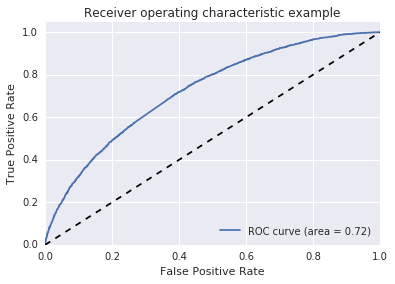

In [88]:
plot_roc_curve(test_data.label,clf.predict_proba(test_vect)[:,1])

In [97]:
# grid search
from sklearn.grid_search import GridSearchCV
clf = Pipeline([('tf_idf', TfidfVectorizer()),
               ('model',LogisticRegression())])

params = dict(tf_idf__max_df=[0.95, 0.85],
             tf_idf__min_df=[2,5],
             tf_idf__max_features=[None, n_features],
             tf_idf__stop_words=['english', None],
             tf_idf__ngram_range=[(1,1),(1,3),(1,6)],
             model__C=[0.5,1,2])
grid_search = GridSearchCV(clf, param_grid=params,verbose=1,n_jobs=-1)

grid_search.fit(train_data.tweet.values, train_data.label)

[Parallel(n_jobs=-1)]: Done  49 tasks       | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 199 tasks       | elapsed:  8.3min


Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 18.0min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('tf_idf', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=Tr...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'model__C': [0.5, 1, 2], 'tf_idf__ngram_range': [(1, 1), (1, 3), (1, 6)], 'tf_idf__max_features': [None, 1000], 'tf_idf__max_df': [0.95, 0.85], 'tf_idf__stop_words': ['english', None], 'tf_idf__min_df': [2, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [111]:
grid_search.best_params_

{'model__C': 2,
 'tf_idf__max_df': 0.95,
 'tf_idf__max_features': None,
 'tf_idf__min_df': 2,
 'tf_idf__ngram_range': (1, 3),
 'tf_idf__stop_words': None}

In [112]:
print(roc_auc_score(test_data.label, grid_search.predict_proba(test_data.tweet)[:,1]))

0.750104010573


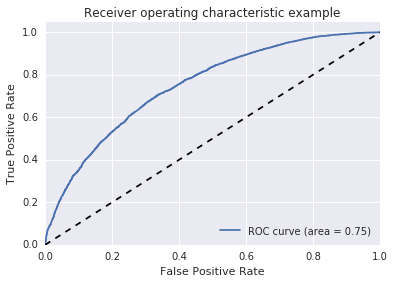

In [198]:
clf = Pipeline([('tf_idf', TfidfVectorizer()),
               ('model',LogisticRegression())])

clf.set_params(**grid_search.best_params_)
clf.fit(train_data.tweet.values, train_data.label)
plot_roc_curve(test_data.label, clf.predict_proba(test_data.tweet)[:,1])

In [179]:
print(sum(test_data.label == clf.predict(test_data.tweet))*1.0/len(test_data))

0.6824


In [187]:
test_data['pred'] = clf.predict(test_data.tweet)

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [189]:
test_data[['tweet','pred','label']]

,tweet,pred,label
11841,help\n,False,True
19602,Morgan responds to her name \n,True,True
45519,I cant believe i wouldnt even mind hearing an #Excuseme on #Raw #Change is so needed. \n,False,False
25747,No fuck that like that's not cool at all \n,False,False
42642,that man goes ballistic on the court.\n,True,False
31902,Thanks ... I'm tired 💤\n,False,False
30346,Keyboard Cover Skin Protector FOR HP Pavilion G4 G4-2235DX G4-1010US G4-1016DX \n,False,False
12363,yes hope u like❤️ \n,False,True
32490,I can't \n,False,False
26128,In so serious. It's sad\n,False,False


In [196]:
test_data[['tweet','pred','label']].groupby(['label','pred']).count()

tweet
label pred        
False False   5498
      True    1542
True  False   2428
      True    3032

In [199]:
n_gram_weight = pd.DataFrame()
b=clf.named_steps['tf_idf']
n_gram_weight['n_gram']=(map(lambda x: x[1],sorted(map(lambda x: (b.vocabulary_[x], x), b.vocabulary_))))
n_gram_weight['weight']=(clf.named_steps['model'].coef_.T[:,0])

In [200]:
pd.options.display.max_rows=999

In [203]:
Top_N = 100
print('TOP %d Negative words' % Top_N)
n_gram_weight.sort_values(by='weight').head(Top_N)

TOP 100 Negative words


,n_gram,weight
27441,miss,-6.367459
49697,wish,-5.423958
35643,sad,-5.338546
27566,missing,-4.403532
43944,tired,-4.242952
37196,sick,-4.107634
17521,hate,-3.737570
25765,lt,-3.713666
47366,want,-3.676667
52430,zayn,-3.575492


In [202]:
print('TOP %d Positive words' % Top_N)
n_gram_weight.sort_values(by='weight', ascending=False).head(Top_N)

TOP 20 Positive words


,n_gram,weight
48053,wcw,3.776379
14961,funny,3.727921
24985,lmao,3.663118
23794,laugh,3.572267
30022,nigga,3.461507
23040,kanye,3.330243
12804,facetimemenash,3.160573
50922,you,3.134933
2075,amber,3.120014
30060,niggas,3.080018


In [ ]:
# 1-gram with tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=n_features,
                                   stop_words='english',ngram_range=(1, 6))

train_vect = tfidf_vectorizer.fit_transform(train_data.tweet.values)
test_vect = tfidf_vectorizer.transform(test_data.tweet.values)

In [21]:
# 1-gram with NO tf-idf
train_vect = tf_vectorizer.fit_transform(train_data.tweet.values)
test_vect = tf_vectorizer.transform(test_data.tweet.values)


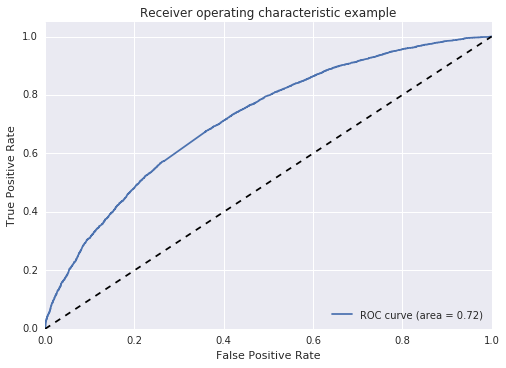

In [22]:
clf = LogisticRegression(C=0.1, penalty='l2')
clf.fit(train_vect, train_data.label)
plot_roc_curve(test_data.label,clf.predict_proba(test_vect)[:,1])

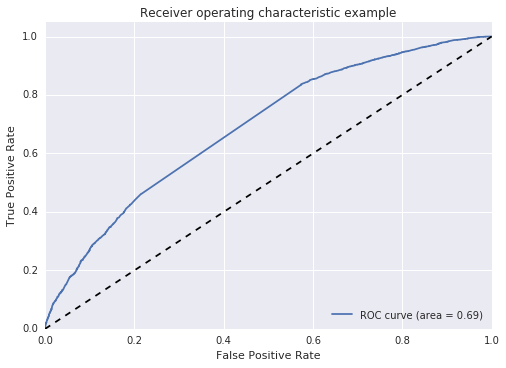

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
import sklearn
clf = Pipeline([('k_best',sklearn.feature_selection.SelectKBest(k=1000)),
        ('clf',RandomForestClassifier(n_estimators=1000, max_depth=5))])
clf.fit(train_vect, train_data.label)
plot_roc_curve(test_data.label,clf.predict_proba(test_vect)[:,1])

In [24]:
# after LDA -> Logistic
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_features,
                                stop_words='english')
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                                learning_method='online', learning_offset=50.,
                                random_state=0)

train_vect = tf_vectorizer.fit_transform(train_data.tweet.values)
train_lda = lda.fit_transform(train_vect)
test_vect = tf_vectorizer.fit_transform(test_data.tweet.values)
test_lda = lda.fit_transform(test_vect)


In [28]:
clf = LogisticRegression(C=1, penalty='l2')
clf.fit(train_lda, train_data.label)
roc_auc_score(test_data.label,clf.predict_proba(test_lda)[:,1])
# plot_roc_curve(test_data.label,clf.predict_proba(test_lda)[:,1])

0.51597833156426909

In [45]:
# after LDA -> Logistic
n_topics = 50
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, #max_features=n_features,
                                   stop_words='english')
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5)

train_vect = tfidf_vectorizer.fit_transform(train_data.tweet.values)
train_nmf = nmf.fit_transform(train_vect)
test_vect = tfidf_vectorizer.fit_transform(test_data.tweet.values)
test_nmf = nmf.fit_transform(test_vect)


In [46]:
clf = LogisticRegression(C=0.1, penalty='l1')
clf.fit(train_nmf, train_data.label)
roc_auc_score(test_data.label,clf.predict_proba(test_nmf)[:,1])


0.54658613521894772

In [ ]:
print('a')